<a href="https://colab.research.google.com/github/Muzsek/A.I.-Projects/blob/main/EMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn

In [ ]:
transform = transforms.Compose([
                          transforms.Grayscale(),
                          transforms.RandomRotation(degrees = 15),
                          transforms.Resize((28,28)),
                          transforms.RandomHorizontalFlip(p=0.5),
                          transforms.ToTensor(),
                          transforms.Normalize((0.1738,),(0.3249,)),
                          ])

In [ ]:
train_dataset = torchvision.datasets.EMNIST(root = "./data", split = "byclass",train = True, download = True, transform = transform)
test_dataset = torchvision.datasets.EMNIST(root = "./data", split = "byclass", train = False, download = True, transform = transform)
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

Train dataset: 697932 samples
Test dataset: 116323 samples


In [ ]:
#from torch.utils.data import subset
subset_size = 200000

indices = list(range(len(train_dataset)))
subset_indices = indices[:subset_size]
sub_train_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
print(f"Subseted Train dataset: {len(sub_train_dataset)} samples")

Subseted Train dataset: 200000 samples


In [ ]:
train_dataloader = DataLoader(sub_train_dataset, batch_size =64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [ ]:
mean = 0.0
std = 0.0
total_images = 0

for images, _ in train_dataloader:
    batch_samples = images.size(0)  # batch mérete
    images = images.view(batch_samples, -1)  # flatten: (batch, pixels)
    mean += images.mean(1).sum()
    std += images.std(1).sum()
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f"EMNIST mean: {mean.item():.4f}")
print(f"EMNIST std: {std.item():.4f}")

EMNIST mean: 0.1738
EMNIST std: 0.3249


Train features' shape: torch.Size([64, 1, 28, 28])
Train labels' shape: torch.Size([64])


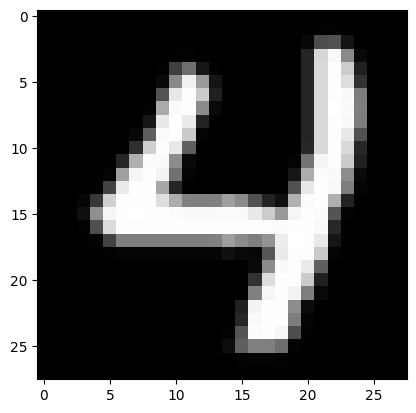

Label: 4


In [ ]:
emnist_byclass_labels = {
    **{i: str(i) for i in range(10)},
    **{i + 10: chr(ord('A') + i) for i in range(26)},
    **{i + 36: chr(ord('a') + i) for i in range(26)}
}
#torch.manual_seed(42)
train_features, train_labels = next(iter(train_dataloader))
print(f"Train features' shape: {train_features.shape}")
print(f"Train labels' shape: {train_labels.shape}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {emnist_byclass_labels[int(label)]}")

In [ ]:
print(f"All classes in EMNIST: {len(train_dataset.classes)}")

All classes in EMNIST: 62


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        self.conv2_block = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 62)  # EMNIST byclass = 62 osztály
        )
    def forward(self, x):
      # x = self.conv1_block(x)
      # print(x.shape)
      # x = self.conv2_block(x)
      # print(x.shape)
      # x = torch.flatten(x, 1)
      # print("After flatten:", x.shape)
      # x = self.classifier(x)
      # return x
      return self.classifier(self.conv2_block(self.conv1_block(x)))
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device: {device}")
model_0 = CNN().to(device)
next(model_0.parameters()).is_cuda

Current device: cuda


True

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

In [ ]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [ ]:
epoch = 3
for epoch in range(epoch):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    test_loss = 0
    model_0.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
          print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
          print(f"Loss: {loss.item()}")
    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n Accuracy:{test_acc:.2f}")


Epoch: 0
-------
Looked at 0/200000 samples
Loss: 4.157873630523682
Looked at 25600/200000 samples
Loss: 1.3981599807739258
Looked at 51200/200000 samples
Loss: 0.6270049214363098
Looked at 76800/200000 samples
Loss: 0.5878857970237732
Looked at 102400/200000 samples
Loss: 0.4247507154941559
Looked at 128000/200000 samples
Loss: 0.586607038974762
Looked at 153600/200000 samples
Loss: 0.5423743724822998
Looked at 179200/200000 samples
Loss: 0.5113822817802429

Train loss: 0.00000 | Test loss: 0.52592, Test acc: 82.21%
 Accuracy:82.21
Epoch: 1
-------
Looked at 0/200000 samples
Loss: 0.6645208597183228
Looked at 25600/200000 samples
Loss: 0.48878178000450134
Looked at 51200/200000 samples
Loss: 0.34480899572372437
Looked at 76800/200000 samples
Loss: 0.5855316519737244
Looked at 102400/200000 samples
Loss: 0.5244772434234619
Looked at 128000/200000 samples
Loss: 0.4147442877292633
Looked at 153600/200000 samples
Loss: 0.5204923152923584
Looked at 179200/200000 samples
Loss: 0.79274958372